# House Prices — Regression Task
Two algorithms: Ridge Regression and Random Forest Regressor. Pipelines include imputation, scaling (for numeric), and one‑hot encoding (for categoricals).

In [1]:
from pathlib import Path
DATA_PATH = Path('../data')
CSV_FILE = DATA_PATH / 'regression.csv'
CSV_FILE

WindowsPath('../data/regression.csv')

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (mean_squared_error, r2_score, classification_report,
                             confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.utils import compute_class_weight

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)


## Load & Clean

In [3]:

df = pd.read_csv(CSV_FILE)
# Drop obvious leakage/IDs
drop_cols = ['id'] if 'id' in df.columns else []
if 'date' in df.columns:
    # Convert date to year, month for signal; exact timestamp can leak
    df['date'] = pd.to_datetime(df['date'])
    df['sale_year'] = df['date'].dt.year
    df['sale_month'] = df['date'].dt.month
    drop_cols.append('date')
df = df.drop(columns=drop_cols)

target = 'price'
y = df[target]
X = df.drop(columns=[target])

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
print(df.shape, 'rows, cols')
df.head()


(21613, 16) rows, cols


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
0,221900.0,3,1.00,1180,5650,1.0,7,1180,0,1955,0,47.5112,-122.257,1340,5650,3
1,538000.0,3,2.25,2570,7242,2.0,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,3
2,180000.0,2,1.00,770,10000,1.0,6,770,0,1933,0,47.7379,-122.233,2720,8062,3
3,604000.0,4,3.00,1960,5000,1.0,7,1050,910,1965,0,47.5208,-122.393,1360,5000,5
4,510000.0,3,2.00,1680,8080,1.0,8,1680,0,1987,0,47.6168,-122.045,1800,7503,3


## Train/Test Split & Preprocessing

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])
categorical_transformer = 'drop'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols)
    ],
    remainder='drop'
)


## Model 1 — Ridge Regression (with alpha tuning)

In [5]:

ridge = Pipeline([('prep', preprocessor), ('model', Ridge(random_state=42))])
grid = {'model__alpha':[0.1, 1.0, 10.0, 100.0]}
ridge_cv = GridSearchCV(ridge, grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ridge_cv.fit(X_train, y_train)
ridge_best = ridge_cv.best_estimator_
print('Best params:', ridge_cv.best_params_)

preds = ridge_best.predict(X_test)
rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f'Ridge — RMSE: {rmse:.3f}, R2: {r2:.3f}')


Best params: {'model__alpha': 100.0}
Ridge — RMSE: 52325382780.950, R2: 0.654


## Model 2 — Random Forest Regressor (tuned)

In [6]:

rf = Pipeline([('prep', preprocessor), ('model', RandomForestRegressor(random_state=42))])
grid = {'model__n_estimators':[300, 600],
        'model__max_depth':[None, 12, 20],
        'model__min_samples_split':[2, 5]}
rf_cv = GridSearchCV(rf, grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)
rf_best = rf_cv.best_estimator_
print('Best params:', rf_cv.best_params_)

preds = rf_best.predict(X_test)
rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f'RandomForest — RMSE: {rmse:.3f}, R2: {r2:.3f}')


Best params: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 300}
RandomForest — RMSE: 27267473076.552, R2: 0.820


## Feature Importance (RF)

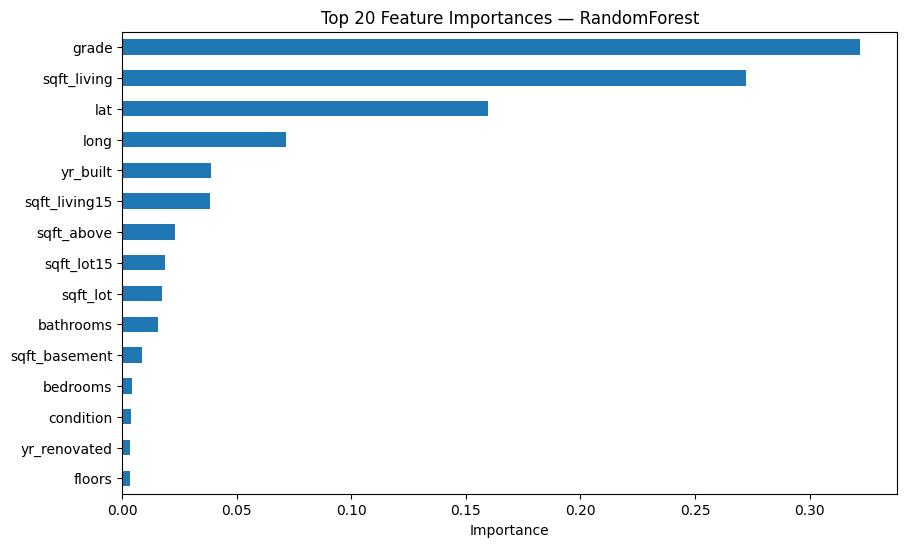

In [7]:

# Feature Importance (RF) — numeric only
feature_names = numeric_cols  # all features are numeric

importances = pd.Series(
    rf_best.named_steps['model'].feature_importances_,
    index=feature_names
).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
importances.plot(kind='barh')
plt.title('Top 20 Feature Importances — RandomForest')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

# save to CSV
fi = importances.reset_index()
fi.columns = ['feature', 'importance']
fi.to_csv(Path('../reports/feature_importance_house_prices.csv'), index=False)



## Save predictions & comparison

In [8]:

out = pd.DataFrame({
    'y_true': y_test,
    'ridge_pred': ridge_best.predict(X_test),
    'rf_pred': rf_best.predict(X_test)
})
out.to_csv(Path('../reports/house_prices_predictions.csv'), index=False)
out.head()


,y_true,ridge_pred,rf_pred
735,365000.0,4.797958e+05,3.798586e+05
2830,865000.0,8.047607e+05,8.903575e+05
4106,1040000.0,1.156562e+06,1.060568e+06
16218,1490000.0,1.609567e+06,2.157738e+06
19964,711000.0,7.391293e+05,7.063026e+05
